In [ ]:
# prompt: mount to drive, cd to summer 2024/group project

from google.colab import drive
drive.mount('/content/drive')

In [2]:
%cd /content/drive/MyDrive/summer2024/group\ project

/content/drive/MyDrive/summer2024/group project


## Load and Review Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
data = pd.read_csv('cleaned_data.csv')
data.head()
print(data.columns)

Index(['latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm'],
      dtype='object')


In [6]:
data.describe().round(3)

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,175272.000,175272.000,175272.000,175272.000,175272.000,175272.000,175272.000,175272.000,175272.000,175272.000
mean,34.899,-105.126,0.262,180.085,11.467,41.398,1.213,7.831,206.094,9.818
std,6.730,24.547,0.473,118.222,13.196,69.269,1.317,11.750,116.463,12.169
min,18.930,-159.708,0.000,5.000,1.000,0.000,0.000,1.000,0.000,0.000
25%,32.700,-118.468,0.000,93.000,2.000,2.000,0.150,1.000,96.000,0.000
50%,35.584,-114.950,0.000,149.000,3.000,13.000,0.770,2.000,219.000,4.000
75%,40.672,-80.237,0.000,237.000,30.000,49.000,1.990,8.000,315.000,16.000
max,47.734,-71.001,3.000,589.000,59.000,966.000,24.130,57.000,365.000,46.000


## Add income_group

### 1. calculate income

In [47]:
# create column income
data['income'] = data['price'] * data['number_of_reviews']

<Axes: >

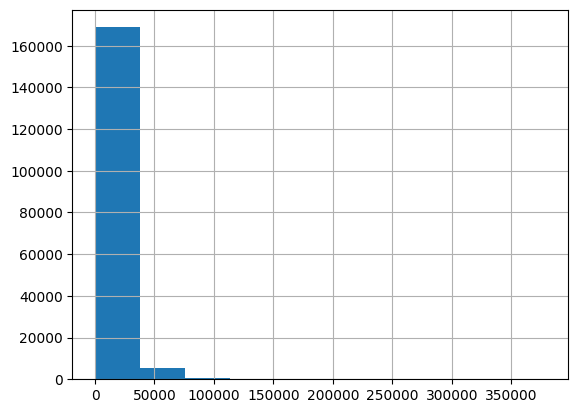

In [32]:
data['income'].hist()

### crop some outliners

Seem like the data is still very skewed, we're gonna crop some outliners

In [48]:
def remove_outliers_iqr(df, columns, th1=0.01, th3=0.90, multiplier=1.5):
    for column in columns:
        Q1 = df[column].quantile(th1)
        Q3 = df[column].quantile(th3)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        print(f"column: {column}, lower_bound: {lower_bound}, upper_bound: {upper_bound}")
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df

data = remove_outliers_iqr(data, ['income'], th1=0.1, th3 = 0.75)

column: income, lower_bound: -11985.75, upper_bound: 19976.25


count    156964.000000
mean       3499.610713
std        4717.597682
min           0.000000
25%         150.000000
50%        1254.000000
75%        5130.000000
max       19976.000000
Name: income, dtype: float64

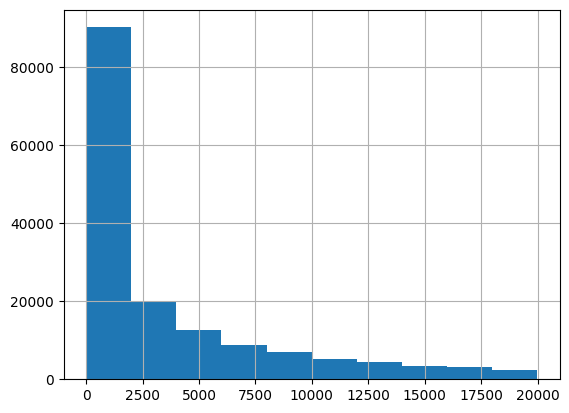

In [49]:
data['income'].hist()
data['income'].describe()

### income_group

It'd be good to divide the group based on the percentiles. This would allows the group proportion to be equal, and the values look quite reasonable

In [56]:
first_quartile = data['income'].quantile(0.25)
second_quartile = data['income'].quantile(0.5)
third_quartile = data['income'].quantile(0.75)
fourth_quartile = data['income'].quantile(1)

data['income_group'] = data['income'].apply(lambda x: 0 if x < first_quartile else 1 if x < second_quartile else 2 if x < third_quartile else 3)

data['income_group'].value_counts()



income_group
1    39513
3    39264
2    39240
0    38947
Name: count, dtype: int64

## Data Prep

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

In [67]:
new_data = data.drop(columns=['income'])

### Scaling

some features use StandardScaler, some use MinMaxscaler

In [68]:
# Select numerical columns for normalization
standardized_cols = ['latitude', 'longitude']  # we use stardard scaler for these columns because there are negative values here

standard_scaler = StandardScaler()

new_data[standardized_cols] = standard_scaler.fit_transform(data[standardized_cols])

# minmax normalization
minmax_cols = ['room_type', 'price' ,'minimum_nights', 'number_of_reviews', 'reviews_per_month',	'calculated_host_listings_count',	'availability_365', 'number_of_reviews_ltm']

min_max_scaler = MinMaxScaler()

new_data[minmax_cols] = min_max_scaler.fit_transform(data[minmax_cols])

In [69]:
new_data.describe()

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,income_group
count,1.569640e+05,1.569640e+05,156964.000000,156964.000000,156964.000000,156964.000000,156964.000000,156964.000000,156964.000000,156964.000000,156964.00000
mean,-8.850776e-16,-5.707374e-16,0.094022,0.285556,0.191094,0.049604,0.043623,0.127630,0.569357,0.178242,1.50216
std,1.000003e+00,1.000003e+00,0.161755,0.195841,0.231171,0.075696,0.051355,0.214561,0.319585,0.238848,1.11649
min,-2.426895e+00,-2.277460e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,-3.498167e-01,-5.733926e-01,0.000000,0.143836,0.000000,0.001988,0.004559,0.000000,0.263014,0.000000,1.00000
50%,9.045036e-02,-1.945224e-02,0.000000,0.231164,0.034483,0.017893,0.024451,0.035714,0.608219,0.065217,2.00000
75%,8.496094e-01,1.007800e+00,0.333333,0.375000,0.500000,0.065606,0.068794,0.142857,0.871233,0.282609,3.00000
max,1.912595e+00,1.387712e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.00000


In [70]:
# income_group and room_type are orginilly categorical, then discrete data, just want to check if they're still are
print(new_data['income_group'].value_counts())
print(new_data['room_type'].value_counts())

income_group
1    39513
3    39264
2    39240
0    38947
Name: count, dtype: int64
room_type
0.000000    114936
0.333333     40124
0.666667      1562
1.000000       342
Name: count, dtype: int64


### Split data to train and test, one hot encode target

In [71]:
X = new_data.drop(columns=['income_group']).values
y = new_data['income_group'].values

#OHE
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Model

In [74]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

### Hyperparameters

In [79]:
input_size = X_train.shape[1]
num_classes = y_train.shape[1]
batch_size = 1000
epochs = 100
learning_rate = 0.001

### Model Init

In [78]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(input_size,)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 26436 (103.27 KB)
Trainable params: 2643

## Train

In [80]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/100
126/126 [==============================] - 5s 25ms/step - loss: 1.1289 - accuracy: 0.4596 - val_loss: 0.8371 - val_accuracy: 0.6301
Epoch 2/100
126/126 [==============================] - 1s 11ms/step - loss: 0.7628 - accuracy: 0.6592 - val_loss: 0.4915 - val_accuracy: 0.8039
Epoch 3/100
126/126 [==============================] - 1s 12ms/step - loss: 0.5061 - accuracy: 0.7847 - val_loss: 0.3327 - val_accuracy: 0.8759
Epoch 4/100
126/126 [==============================] - 1s 11ms/step - loss: 0.3799 - accuracy: 0.8450 - val_loss: 0.2408 - val_accuracy: 0.9165
Epoch 5/100
126/126 [==============================] - 1s 11ms/step - loss: 0.3024 - accuracy: 0.8783 - val_loss: 0.1857 - val_accuracy: 0.9368
Epoch 6/100
126/126 [==============================] - 1s 11ms/step - loss: 0.2570 - accuracy: 0.8971 - val_loss: 0.1531 - val_accuracy: 0.9522
Epoch 7/100
126/126 [==============================] - 1s 11ms/step - loss: 0.2261 - accuracy: 0.9092 - val_loss: 0.1316 - val_accuracy:

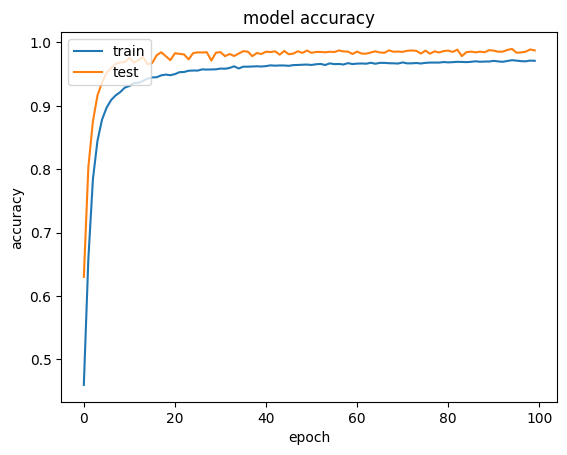

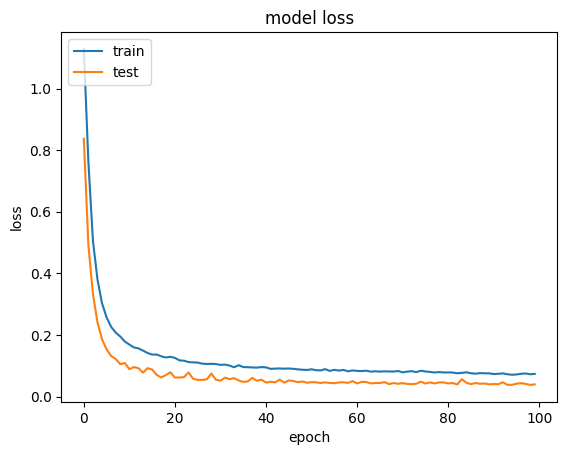

In [81]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [88]:
yhat_test = model.predict(X_test[2:4])
# yhat_test_idx = np.argmax(yhat_test, axis=1)
y_labels = y_test[2:4]
print(yhat_test, y_labels)

1/1 [==============================] - 0s 26ms/step
[[1.3294967e-07 9.9999952e-01 4.0131087e-07 6.1975210e-23]
 [2.5426187e-08 3.8531389e-02 9.6146840e-01 2.2377020e-07]] [[0. 1. 0. 0.]
 [0. 0. 1. 0.]]


## Save Model

In [83]:
model.save('c_model.keras')

## Cross-validation (probably not necessary, since our accuracy is pretty high)

# Suggesting Model

### TODO:
  1. Write script that asks for user's input
  2. redo StardardScaler and MinMaxScaler, we need to record the mean and std of each column, so we can stardardize and normalize user's input manually
  3. Feed user's input to Price Predicting model, get price range
  4. For each price, feed user input + price to this classification model
  5. Report the likelyhood of monthly income, suggest ideal price of the listing